In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [2]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using LuxDeviceUtils: cpu_device, gpu_device
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

Precompiling PhasorNetworks
  ✓ PhasorNetworks
  1 dependency successfully precompiled in 11 seconds. 412 already precompiled.


In [41]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [42]:
spk_args = SpikingArgs(t_window = 0.01, 
                    threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [43]:
# solver_args = Dict(:adaptive => false, :dt => 0.01)

In [44]:
# spk_args = SpikingArgs(t_window = 0.01, 
#                     threshold = 0.001,
#                     solver=Heun(), 
#                     solver_args = solver_args)

In [45]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.dt:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [46]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [47]:
args = Args()

Args(0.0003, 256, 10, false, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [48]:
train_loader, test_loader = getdata(args)
x, y = first(train_loader)

([0.4363590795046628 -0.020726939563912576 … -0.014802110970796872 -0.0019893102515646105; -0.17784306532747968 0.3038012525038328 … -0.07276908176492998 -0.005627426425963785], Bool[0 0 … 1 1; 1 1 … 0 0])

In [49]:
model, ps, st = build_mlp(args)

(Chain(), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.09775257 -0.033171576; 0.020251632 0.0070170956; … ; 0.04797584 0.04434996; -0.002902955 0.14405486], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]), layer_4 = (weight = Float32[-0.7682285 0.26694193 … 0.07480648 0.34993985; 0.15990366 -0.17788795 … -0.27716428 1.1225573], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [50]:
spk_model, _, _ = build_spiking_mlp(args, spk_args)

(Chain(), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.09775257 -0.033171576; 0.020251632 0.0070170956; … ; 0.04797584 0.04434996; -0.002902955 0.14405486], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]), layer_4 = (weight = Float32[-0.7682285 0.26694193 … 0.07480648 0.34993985; 0.15990366 -0.17788795 … -0.27716428 1.1225573], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [51]:
y, _ = model(x, ps, st)

([0.023460582650089865 -0.04065884559668343 … -0.040001288679202614 -0.02289208259651791; -0.007871404888295633 -0.001854986476512754 … -0.0022421150558298263 0.001061405277603678], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [52]:
ps.layer_3.bias

128-element Vector{ComplexF32}:
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
       ⋮
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im
 1.0f0 + 0.0f0im

In [53]:
y_spk, _ = spk_model(x, ps, st)

(SpikingCall(Spike Train: (2, 256) with 5273 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [54]:
p_spk = train_to_phase(y_spk);

In [55]:
size(p_spk)

(10, 2, 256)

In [56]:
size(y)

(2, 256)

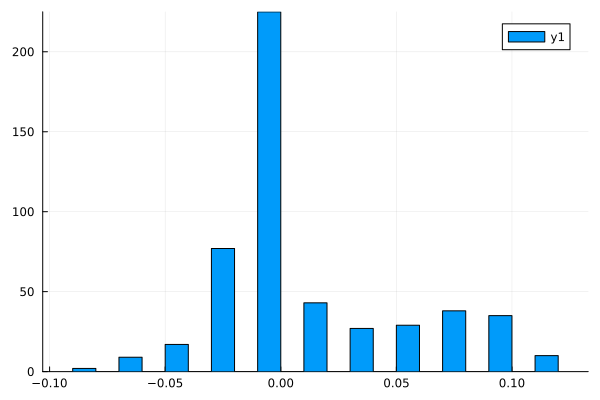

In [57]:
histogram(vec(p_spk[5,:,:]))

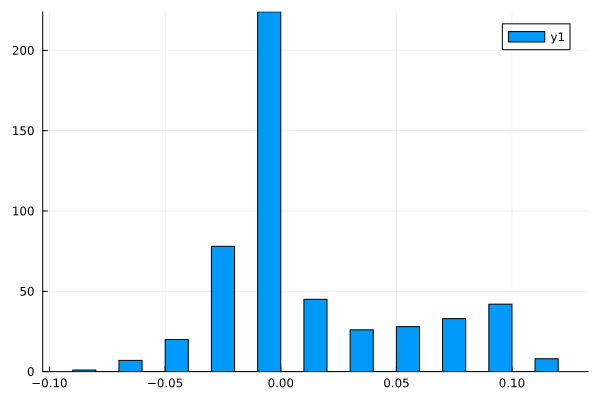

In [58]:
histogram(vec(p_spk[6,:,:]))

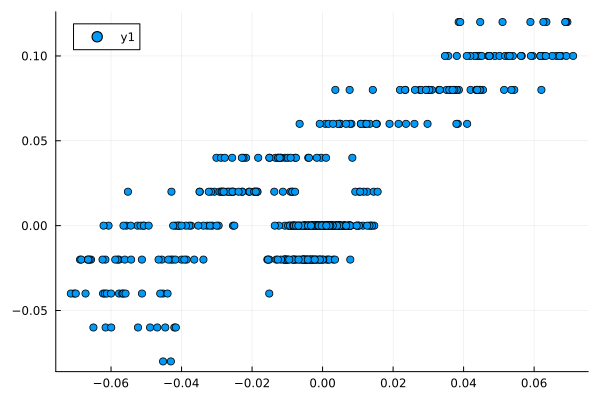

In [59]:
scatter(vec(y), vec(p_spk[5,:,:]))

In [60]:
cycle_correlation(y, p_spk)

10-element Vector{Float64}:
 0.30062263904647213
 0.5963475104387989
 0.6938221492703986
 0.7383858795633736
 0.7691823159179625
 0.775830975446228
 0.787418650043094
 0.7963171427859194
 0.8044626506399276
 0.5772823929952641